### **Correlating Social Vunerability Measures for Los Angeles County to High Land Surface Temperature (LST)**
Pa-Shun Hawkins (member of climate group)

This Journal follows Aneesa's notebook and proceeds Yu's. Aneesa's notebook will asses the distribution of heat, and will be compared to three measures of social vunerability.  These variables were taken from Environmental Systems Research Institute, Inc. and the data set used was their: Heat Health Census Tracts 

(link to data set: https://gis-for-racialequity.hub.arcgis.com/datasets/7f05981247034b5da1887f14b7ed523b_0/about)

As stated in Aneesa's notebook, heatwaves exert a significant impact on society, leading to a noticeable increase in heat-related fatalities. The worsening effects of climate change are intensifying the occurrence and severity of heatwaves, affecting Los Angeles (LA), California.

According to "Vulnerability to Extreme Heat in Metropolitan Phoenix 289" (Winston et al.) 
minorities, household income, and population mobility reflect a person's ability to cope and adapt to heat. 

Our goal is to identifiy how measures of social vunerability relate to extreme heat in Los Angeles California. 

Designated Responsibilities for variables
- **PaShun**: Minoritiy Distribution
- **Aneesa**: Household income
- **Yu**: Population mobility 

This notebook focuses on examining the distribution of minorities in Los Angeles, and correlates minority abundance to high land surface temperatures (LST). At the end, there is also a scatter plot correlating population mobility to high LST this was done in collaboration with Yu to help correlate his variable to high LST.

In [30]:
pip install pysal > pysal_installation_log.txt

Note: you may need to restart the kernel to use updated packages.


In [31]:
#Impoting libraries 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd
import seaborn as sns
from scipy.stats import linregress
import contextily as ctx
import pysal.lib
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster
import pysal.explore.esda as esda

ImportError: cannot import name 'Local_Spatial_Pearson' from 'esda.lee' (/opt/conda/lib/python3.11/site-packages/esda/lee.py)

### **Analyzing Correlation Between Abundance of Minorities and High Land Surface Temperature in LA County**

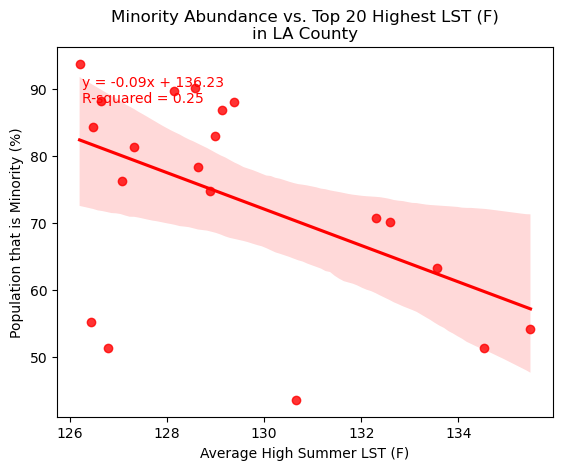

In [32]:
# Load CSV file and filter rows for LA
df = pd.read_csv('Data/Heat.csv', dtype={'GEOID': str, 'SHAPE_Length': str, 'SHAPE_Area': str})
california_df = df[df['County'] == 'Los Angeles County']

columns_to_keep = ['GEOID', 'PCT_Pop_Minority','High_Summer_Mean_LST_F','B08201_calc_pctNoVehE', 'State', 'County', 'SHAPE_Length', 'SHAPE_Area']
df2 = california_df[columns_to_keep]

df2.columns = ['FIPS', 'Percent_of_Population_that_is_Minority','High_Summer_Mean_LST_F','Percent_of_HHs_with_No_Vehicle', 'State', 'County', 'SHAPE_Length', 'SHAPE_Area']

tracts = gpd.read_file('Data/Census_Tracts.geojson')[['CT20', 'geometry']]
tracts['FIPS'] = '06037' + tracts['CT20']

tracts_health = tracts.merge(df2, on="FIPS")

# Remove NaN values
tracts_health2 = tracts_health.dropna(subset=['Percent_of_Population_that_is_Minority', 'High_Summer_Mean_LST_F'])

# Sort by 'High_Summer_Average_Surface_Temperature' and select top 20
top_20_data = tracts_health2.sort_values(by='High_Summer_Mean_LST_F', ascending=False).head(20)

# Plotting scatter plot with regression line using seaborn 
sns.regplot(x='High_Summer_Mean_LST_F', y='Percent_of_Population_that_is_Minority', data=top_20_data, color='red')

# Calculate regression line parameters
slope, intercept, r_value, p_value, std_err = linregress(top_20_data['Percent_of_Population_that_is_Minority'], top_20_data['High_Summer_Mean_LST_F'])

# Add regression line equation to the plot 
plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}\nR-squared = {r_value**2:.2f}', 
             xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, color='red')

# Set plot labels and title
plt.xlabel('Average High Summer LST (F)')
plt.ylabel('Population that is Minority (%)')
plt.title('Minority Abundance vs. Top 20 Highest LST (F)\nin LA County')

# Show the plot
plt.show()


**Interpreting correlation**

R^2 =0.25 indicates that 25% of the variability in land surface temperature can be explained by the abundance of minorities. While the R^2 of 0.25 is relatively low, it still suggests a moderate relationship between the variables. Additionally, the negative sign suggests an inverse relationship, meaning that as the abundance of minorities increases, the land surface temperature tends to decrease.

Overall, we can conclude that there is a statistically significant, moderate, inverse relationship between the abundance of minorities and high land surface temperature in LA County. 

### **Spatial Distribution of Minority Populations and Quantitative Analysis of Spatial Autocorrelation using Local Moran's I**

/tmp/ipykernel_120/1204741723.py:23: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = pysal.lib.weights.Rook.from_dataframe(tracts_health2)
/opt/conda/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 4 islands with ids: 1881, 1882, 1908, 1940.
  warnings.warn(message)


('WARNING: ', 1881, ' is an island (no neighbors)')
('WARNING: ', 1882, ' is an island (no neighbors)')
('WARNING: ', 1908, ' is an island (no neighbors)')
('WARNING: ', 1940, ' is an island (no neighbors)')
Global Moran's I index number: 0.8820863881728703


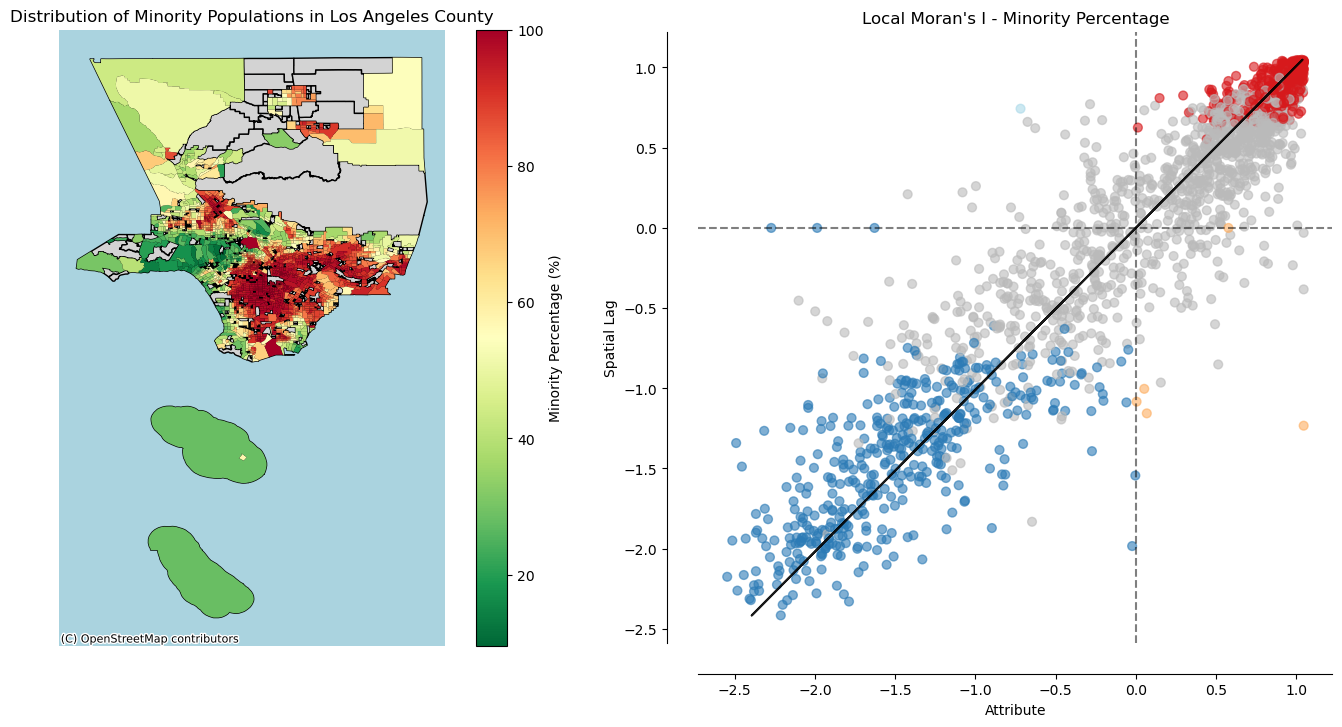

In [34]:
# Plotting the static map with basemap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot Census Tract boundaries
tracts.plot(ax=ax1, color='lightgray', edgecolor='black')

# Plot distribution of minorities
tracts_health2.plot(ax=ax1, column='Percent_of_Population_that_is_Minority', cmap='RdYlGn_r', legend=True, legend_kwds={'label': 'Minority Percentage (%)'})

# Add streets and city names 
ctx.add_basemap(ax1, zoom=11, source=ctx.providers.OpenStreetMap.Mapnik)

# Remove axes on the map
ax1.set_axis_off()

# Set the title
ax1.set_title('Distribution of Minority Populations in Los Angeles County')

# Spatial autocorrelation analysis
y = tracts_health2['Percent_of_Population_that_is_Minority'].values

# Create spatial weights using Rook contiguity
w = pysal.lib.weights.Rook.from_dataframe(tracts_health2)

# Global Moran's I
moran = esda.Moran(y, w)
print("Global Moran's I index number:", moran.I)

# Local Moran's I
moran_loc = esda.moran.Moran_Local(y, w)

# Moran Scatterplot
moran_scatterplot(moran_loc, ax=ax2, p=0.05)
ax2.set_title('Local Moran\'s I - Minority Percentage')

# Display the plot
plt.show()


The global Moran's I index number: 0.882, indicates a strong positive spatial autocorrelation. Because the value is close to 1, there is a strong positive spatial autocorrelation, meaning that similar values are clustered together on the map. In the context of analyzing minority distribution, this means that areas with high percentages of minority populations are clustered together spatially, and likewise, areas with low percentages of minority populations are also clustered together. This is also evident in the distribution graph to the left where most minorities are centered in the lower middle region of LA. 


### **Analyzing Correlation Between Households with no Vechicles and High Land Surface Temperature in LA County**

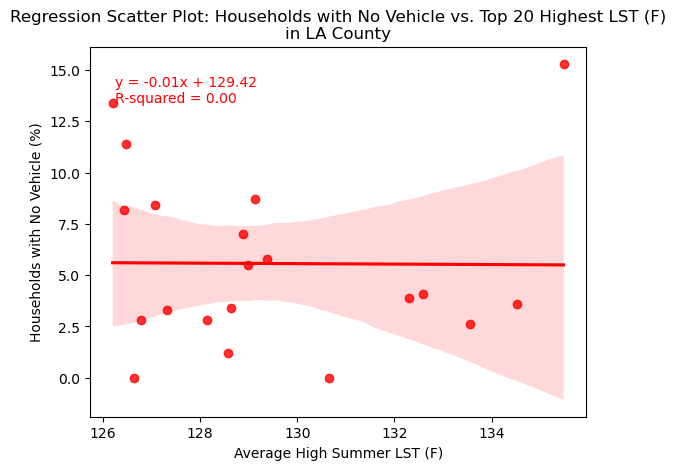

In [36]:
# Sort by 'High_Summer_Mean_LST_F' and select top 20
top_20_data_no_vehicle = tracts_health2.sort_values(by='High_Summer_Mean_LST_F', ascending=False).head(20)

# Plotting scatter plot with regression line 
sns.regplot(x='High_Summer_Mean_LST_F', y='Percent_of_HHs_with_No_Vehicle', data=top_20_data_no_vehicle, color='red')

# Calculate regression line parameters
slope_no_vehicle, intercept_no_vehicle, r_value_no_vehicle, p_value_no_vehicle, std_err_no_vehicle = linregress(top_20_data_no_vehicle['Percent_of_HHs_with_No_Vehicle'], top_20_data_no_vehicle['High_Summer_Mean_LST_F'])

# Add regression line equation to plot 
plt.annotate(f'y = {slope_no_vehicle:.2f}x + {intercept_no_vehicle:.2f}\nR-squared = {r_value_no_vehicle**2:.2f}', 
             xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, color='red')

# Set plot labels and title
plt.xlabel('Average High Summer LST (F)')
plt.ylabel('Households with No Vehicle (%)')
plt.title('Regression Scatter Plot: Households with No Vehicle vs. Top 20 Highest LST (F)\nin LA County')

# Show the plot
plt.show()


A R^2 value of 0 suggests that none of the variability in the average summer temperature is explained by the percentage of households with no vehicles. Although the slope of the regression line indicates a slight decrease in average summer temperature as the percentage of households with no vehicles increases, this relationship is not strongly supported by the data. 

This observation aligns with Yu's notebook, where the predominance of green in his map (map showing vechical ownership) indicates widespread vehicle ownership in LA. Therefore, vehicle possession appears not to be a major concern for LA residents seeking relief from the heat.

**Group Contribution:** Although each of us individually mapped and assessed three distinct variables in relation to heat (Aneesa focused on Income & High LST, Pa-Shun on Minority Distribution and its correlation to heat, and Yu on Vehicle Possession and its correlation with heat), we maintained regular meetings and actively collaborated to support one another with coding and interpreting the statistical analysis.
